In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.text import OffsetFrom
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp, RK45

from F_R_Tools import MJW, STBS, HUSAW
from F_R_Tools import ModelFR

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

#Science plots 
# pip install git+https://github.com/garrettj403/SciencePlots

plt.style.use(['science','grid'])


# f(R) SSS Solver 

#### This notebook is intended to showcase the numerical solutions for a given $f(R)$ model given a matter density distribution and forms part of my Master Thesis "Non-linear analysis of solar system tests in $f(R)$ gravity" 

This notebook shows how to:
- implement the F_R_Tools classes
- solve numerically the $f(R)$ equations assuming spherically symmetric and static spacetimes using Scipy solve_ivp
- illustrate the results for a given initial condition of $R$ at $r=0$

In [ ]:

#Physical constants
from scipy.constants import G 
from scipy.constants import c
from astropy.constants import M_sun
from astropy.cosmology import WMAP9 as cosmo #For the hubble parameter
from scipy.constants import parsec as _pc

_Mpc = 1e+6*_pc
_Gpc = 1e+9*_pc

H0 = cosmo.H(0)
H0 =  H0.value*(1000)/_Mpc # Mpc = 3.0851e22m and 1 km = 1000m 

M_sun = M_sun.value #in Kg
r_sun = 696340*1000 # In meters
R_swarzchild_sun = 2*G*M_sun/c**2
r_c = 10**(5)*(1000)# 1km= 1000m, We opt for 100,000 km as a charateristical unit 
rho_sun = 1.408/1000*100**3  # 1408 kg m ^-3

T_sun = rho_sun*c**2
R_sun = 8*np.pi*G*T_sun/c**4
p_sun = 1.01232*10**(16)
R_ast = H0**2 /c**2
rho_ast = c**2/(8*np.pi*G)*R_ast


In [ ]:
def SigmaUnits(sigma,factor, method =1 ):

    """This functions returns the value of the dimensionless 
    coefficients appering in the field Eqs. 
    
    """

    if method == 1:

        rho_sigma = sigma * rho_ast
        R_sigma = 8*np.pi*G/c**2*rho_sigma
        R_tilde = R_ast/R_sigma
        r_sigma = np.sqrt(R_sun/R_sigma)*r_c
    
        T_sigma = rho_sigma*c**2
        alpha = 16*np.pi*G*r_sigma**2*T_sigma/c**4
        beta= r_sigma**2*R_sigma
        
        A =np.array([alpha, beta, R_tilde, T_sigma, T_sun, r_sigma, R_sigma])
        return A
    
    elif method == 2:

        rho_sigma = sigma * rho_ast
        R_c = R_ast
        r_c = np.sqrt(R_c)**(-1)#/mp.mpmathify(1e5*(1e3))
        T_c = rho_sigma*c**2
        
        alpha= 8*np.pi*G*r_c**2*T_c/c**4
        beta= r_c**2*R_c
        R_tilde = factor*R_ast/R_c
        
        A =np.array([alpha, beta, R_tilde, T_c, T_sun, r_c, R_c])
        return A

def F_GR(R):
    """This functions returns f(R)=R"""

    return  R


def F_GR__LAMBDA(R):
    """This functions returns f(R)=R + Lambda"""
    Lambda = 2.08
    return  R - 2*Lambda

EXPONENT = 0 
Zigma = 10**EXPONENT
alpha, beta, R_tilde, T_sigma, T_0, r_sigma, R_sigma = SigmaUnits(Zigma,4.17,method = 2)

alpha,beta,R_tilde,T_sigma, T_0, r_sigma, R_sigma 

In [49]:
## Parameters for the  Hu-Sawicki model

c_1 = 1.25e-3 
c_2 = 6.56e-5
n = 4
m2 = 0.24


## Parameters for the  Starobinsky  model
def Parameters_STBS(model):
    if model == "Koba_n_1":
        # x_1 = 3.6 Notation of KObaMaeda
        llambda = 2.088
        q=1
        A_S= 1
        R_tilde = 1*A_S
        args = [llambda, R_tilde,q]
        return  args
    elif model == "Koba_n_2":
        llambda = 1.827
        q=2
        A_S= 1
        R_tilde = 1*A_S
        args = [llambda, R_tilde,q]
        return  args
    elif model == "Luisa_STBS":
        ñlambda = 1
        q=2
        A_S= 4.17
        R_tilde = 1*A_S
        args = [llambda, R_tilde,q]
        return args

    

args_STBS = Parameters_STBS("Koba_n_1")
lambda_s, R_tilde, q  = args_STBS


## Parameters for the  MJW  model
alpha_m = 2
R_tilde_MJW =  1


In [50]:
# Definition of the main functions for the three  models

HUSAW_MODEL = HUSAW(m2, c_1, c_2, n)

STBS_MODEL = STBS(R_tilde,lambda_s,q)
STBS_beta_coef = ModelFR(STBS_MODEL,alpha,beta).beta_coef


MJW_MODEL =  MJW(1, 2)

# The root corresponds to the assymptotic value of the Ricci Scalar

root_STBS  = fsolve(STBS_beta_coef,3, xtol=1e-16)

print(root_STBS)


[3.59880517]


In [ ]:
#This functions corresponds to conditions that we need to supply to the Scipy Integrator

## First Test Events in the terminology of the Class ModelFR
def firstest_event_p(r,z):
    #Event where the pressure vanishes (p=0)
    return z[4]
firstest_event_p.terminal = True
firstest_event_p.direction = -1


def firstest_event_root(r,z):
    #Event where the the value of R is the same as the "root" 
    return z[0]-root 

firstest_event_root.terminal = False
firstest_event_root.direction = 0

def firstest_event_n(r,z):
    #Event where the radial component n(r) vanishes, meaning the cosmological horizon
    return z[3]
firstest_event_n.terminal = True
firstest_event_n.direction = -1



## Second Test Events in the terminology of the Class ModelFR

def event1_secondtest(r,z,rho):
    #Event where the pressure vanishes (p=0)
    return z[5]
event1_secondtest.terminal = True
event1_secondtest.direction = -1

def event2_secondtest(r,z,rho):
    #Event where the the value of R is the same as the "root" 
    return z[0]-root 
event2_secondtest.terminal = False
event2_secondtest.direction = 0

def event3_secondtest(r,z,rho):
    #Event where the radial component n(r) vanishes, meaning the cosmological horizon
    return z[3]
event3_secondtest.terminal = True
event3_secondtest.direction = -1


In [263]:
def Solver_SSS(F_R_Model, y0, rho_in, test="First_Test", r_infinty = 5):
    """
    Solver for the f(R) SSS field equations
    
    ----------
    y0 : array_like, shape (n,)
        Initial condition.

    test : integer
         Used for select whether is the first or second of equivalent equations
         options: "First_Test" or "Second_Test"
         
    F : function
        Python function defining the f(R) model.

    rho : float
        Matter distribution  
    """
    r_span_in = [1e-10,1e-2]
    Arguments_in = None #(1,)    #Put a coma to be a tuple  or []. Rho=1
    Arguments_out  = None #(0,)  #Put a coma to be a tuple  or []. Rho=0
    
    if test == "First_Test":
        First_test_in = ModelFR(F_R_Model ,alpha,beta, rho = rho_in).first_test

        #Interior solution
        sol_in = solve_ivp(First_test_in, r_span_in, y0, 
                         method='DOP853',rtol = RTOL, atol=ATOL, t_eval=None, 
                         dense_output=False, events=firstest_event_p, 
                         vectorized=False,args=Arguments_in)
        
        if sol_in.y_events[0].size == 0:
            print('There is no outside solution')
            return  sol_in
        else: 
            #The initial conditions for the exterior solution 
            R_0out, Rprime_0out, m_0out, n_0out, p_0out = sol_in.y_events[0][0]
            y0out = [R_0out,Rprime_0out,m_0out ,n_0out ,int(p_0out)]
            #The density is vanishes outside the star
            First_test_out = ModelFR(F_R_Model ,alpha,beta, rho = 0.0).first_test

        #Outside solution 
        r_span_out = [sol_in.t_events[0][0], r_infinty ]

        sol_out = solve_ivp(First_test_out, r_span_out, y0out,
                         method='DOP853', t_eval=None,rtol = RTOL, atol=ATOL, 
                         dense_output=False, events=None, 
                         vectorized=False,args=Arguments_out)
        
        #if sol_out.t_events[1].size>0:
         #   r = np.linspace(sol_in.t_events[0][0] ,sol_out.t_events[1][0] , 100000)
        #else:
         #   r = np.linspace(sol_in.t_events[0][0] ,sol_out.t[-1] , 100000)
        return sol_in, sol_out
    
    elif test == "Second_Test":
        #Remember that this test has one more condition 
        sol_in_2ndtest =solve_ivp(Miranda_2test, r_span_in, y0, 
                                  method='DOP853',rtol = RTOL, atol=ATOL, t_eval=None, 
                                  dense_output=True, events=event_secondtest, 
                                  vectorized=False,args=Arguments_in)
        if sol_in_2ndtest.y_events[0][0].size == 0:
            return print('There is no outside solution'), sol2
        
        else: 
            R_0out, Rprime_0out, m_0out, n_0out, n_prime_0out, p_0out = sol_in_2ndtest.y_events[0][0]
            y0out = [R_0out,Rprime_0out,m_0out ,n_0out, n_prime_0out,int(p_0out)]
         #Outside solution 
        r_span_out = [sol_in_2ndtest.t_events[0][0], r_infinty ]
        sol_out_2ndtest =solve_ivp(Miranda_2test, r_span_out, y0out, 
                                    method='DOP853',rtol = RTOL, atol=ATOL, t_eval=None, 
                                    dense_output=True, events=[event2_secondtest,event3_secondtest],
                                    vectorized=False,args=Arguments_out)
        if sol_out_2ndtest.t_events[1].size>0:
            r = np.linspace( sol_in_2ndtest.t_events[0][0] , sol_out_2ndtest.t_events[1][0] , 100000)
        else:
            r = np.linspace( sol_in_2ndtest.t_events[0][0] ,sol_out_2ndtest.t[-1] , 100000)
        
        return sol_in_2ndtest, sol_out_2ndtest,r
    


In [280]:

def density_magnitude(exp, conf, root):
    """This function returns the density as a float

    ----------
    exp : integer
        Exponential to escalate the density.

    conf : integer
         Different expressions corresponding to
         "Luisa": As seen in  [aXiv:1006.5747]
         
    root : float
        The assymptotic value of the Ricci Escalar
    """
    if conf =='Luisa':
        rho_LUISA_STBS = float(10**exp*root*R_ast*c**2/(16*G*np.pi)/rho_ast)
        return  rho_LUISA_STBS
    elif conf == 'Koba_Maeda':
        rho = float(10**exp*root*R_ast*c**2/(16*G*np.pi)/rho_ast)
        return rho 
    
rho_LUISA_STBS = density_magnitude(6,'Koba_Maeda', root_STBS)

print('The density in  $\\rho_*$ is %.4e' %(rho_LUISA_STBS))
print('The density in kgm^-3 is %.4e' %(rho_LUISA_STBS*rho_ast))

The density in  $\rho_*$ is 1.7994e+06
The density in kgm^-3 is 5.4138e-21


### Define initial parameters

We choose to solve the Starobinsky $f(R)$ model with initial condition $R_c = 6.2502$ which was prevously obtained with the shooting method. This solution corresponds to Figure 4.19 of the Thesis.

In [273]:
#Fixed initial conditions 

Rprime_0 = 0
m_0 = 1
n_0 = 1
p_0 = 0.05*rho_LUISA_STBS


#Scales for the relative errors
scale = 1e-8
RTOL =  1e-12
ATOL = scale*RTOL

R_0= 6.2502
y0 = [R_0, Rprime_0, m_0, n_0, p_0]

r_span_in = [1e-16,1e-2]
r_infinty= 5



### Visualize numerical solution

In [274]:
sol_1, sol_2 = Solver_SSS(STBS_MODEL, y0, rho_LUISA_STBS, test="First_Test")

In [275]:
def plot_solution(sol_in, sol_out):

    """This functions plot the solution given a the interior and exterior solution"""

    fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout=True, figsize=(3.3*2 , 2.5))


    r_in = sol_in.t
    R_in = sol_in.y[0]
    RPrime_in = sol_in.y[1]
    m_in = sol_in.y[2]
    n_in = sol_in.y[3]
    p_in = sol_in.y[4]

    r_out = sol_out.t
    R_out = sol_out.y[0]
    RPrime_out = sol_out.y[1]
    m_out = sol_out.y[2]
    n_out = sol_out.y[3]
    p_out = sol_out.y[4]

    rr = np.concatenate((r_in, r_out), axis=None)
    RR = np.concatenate((R_in, R_out), axis=None)
    pp = np.concatenate((p_in, p_out), axis=None)
    rr = np.concatenate((r_in, r_out), axis=None)
    mm = np.concatenate((m_in, m_out), axis=None)
    nn = np.concatenate((n_in, n_out), axis=None)


   
  

    ax1.plot(np.log10(rr),  RR,  linewidth=1.2 )
    ax1.plot(np.log10(r_out[0]),  R_out[0], "*",color="red" )
    
    ax2.plot(np.log10(r_out[0]),m_out[0], "*",color="red" )
    ax2.plot(np.log10(rr),mm, label="$m(r)$" )

    epsilon = 2e-1
    y_down = 1 -1.5*epsilon
    y_up =1 + 1.5*epsilon

    ax2.plot(np.log10(r_out[0]),n_out[0]/np.max(n_out), "*",color="red" )
    ax2.plot(np.log10(rr),nn/np.max(n_out),label="$n(r)$")


    ax2.plot(np.log10(rr),nn/np.max(n_out)*mm,"-.", label="$m(r)n(r)$")
    ax2.plot(np.log10(r_in[-1]), n_in[-1]/np.max(n_out)*m_in[-1], "*",color="red")

    ax2.set_ylim( y_down, y_up)

    label_Ricci = "$\\lambda =$%.5s \n $q=$ %s " %(lambda_s, q)

    ax1.set_xlabel("$\log_{10}(r[R_*^{-1/2}])$")
    ax1.set_ylabel("$R[R_*]$")


    ax2.set_xlabel("$\log_{10}(r[R_*^{-1/2}])$")

    ax1.legend(title = label_Ricci)
    ax2.legend()

    fig.savefig('Plots/Solution.pdf')

    plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


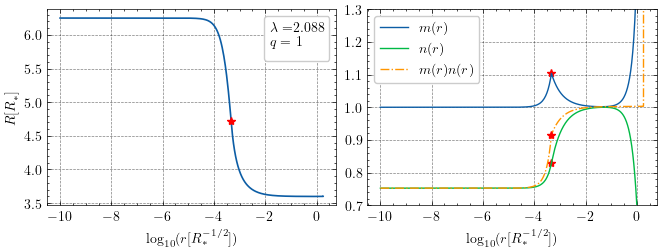

In [276]:
plot_solution(sol_1, sol_2)